In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
warnings.filterwarnings('ignore')

from pyinform.blockentropy import block_entropy

In [2]:
path = 'C:/Users/camer/OneDrive/Documents/dev/home_research/data/volatility_prediction_optiver/'

In [3]:
book_train_all_stocks = []
for i in range(127):
    try:
        book_train = pd.read_parquet(path + 'book_train.parquet/stock_id=' + str(i))
        book_train['stock_id'] = i
        book_train_all_stocks.append(book_train)
        print('added stock', i)
    except: 
        continue
book_train_all_stocks = pd.concat(book_train_all_stocks)
print('completed_concatenation')
book_train_all_stocks

added stock 0
added stock 1
added stock 2
added stock 3
added stock 4
added stock 5
added stock 6
added stock 7
added stock 8
added stock 9
added stock 10
added stock 11
added stock 13
added stock 14
added stock 15
added stock 16
added stock 17
added stock 18
added stock 19
added stock 20
added stock 21
added stock 22
added stock 23
added stock 26
added stock 27
added stock 28
added stock 29
added stock 30
added stock 31
added stock 32
added stock 33
added stock 34
added stock 35
added stock 36
added stock 37
added stock 38
added stock 39
added stock 40
added stock 41
added stock 42
added stock 43
added stock 44
added stock 46
added stock 47
added stock 48
added stock 50
added stock 51
added stock 52
added stock 53
added stock 55
added stock 56
added stock 58
added stock 59
added stock 60
added stock 61
added stock 62
added stock 63
added stock 64
added stock 66
added stock 67
added stock 68
added stock 69
added stock 70
added stock 72
added stock 73
added stock 74
added stock 75
added

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
...,...,...,...,...,...,...,...,...,...,...,...
1042044,32767,588,0.999229,1.000051,0.999177,1.000103,100,200,28,100,126
1042045,32767,589,0.999229,1.000051,0.999177,1.000103,100,200,1,100,126
1042046,32767,590,0.999229,0.999794,0.999177,1.000051,101,27,1,200,126
1042047,32767,592,0.999229,0.999743,0.999177,1.000051,101,11,1,200,126


In [4]:
trade_train_all_stocks = []
for i in range(127):
    try:
        trade_train = pd.read_parquet(path + 'trade_train.parquet/stock_id=' + str(i))
        trade_train['stock_id'] = i
        trade_train_all_stocks.append(trade_train)
        print('added stock', i)
    except: 
        continue
trade_train_all_stocks = pd.concat(trade_train_all_stocks)
print('completed_concatenation')
trade_train_all_stocks.head()

added stock 0
added stock 1
added stock 2
added stock 3
added stock 4
added stock 5
added stock 6
added stock 7
added stock 8
added stock 9
added stock 10
added stock 11
added stock 13
added stock 14
added stock 15
added stock 16
added stock 17
added stock 18
added stock 19
added stock 20
added stock 21
added stock 22
added stock 23
added stock 26
added stock 27
added stock 28
added stock 29
added stock 30
added stock 31
added stock 32
added stock 33
added stock 34
added stock 35
added stock 36
added stock 37
added stock 38
added stock 39
added stock 40
added stock 41
added stock 42
added stock 43
added stock 44
added stock 46
added stock 47
added stock 48
added stock 50
added stock 51
added stock 52
added stock 53
added stock 55
added stock 56
added stock 58
added stock 59
added stock 60
added stock 61
added stock 62
added stock 63
added stock 64
added stock 66
added stock 67
added stock 68
added stock 69
added stock 70
added stock 72
added stock 73
added stock 74
added stock 75
added

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002818,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0


In [5]:
train_stock0 = pd.merge(book_train_all_stocks[book_train_all_stocks['stock_id']==0], trade_train_all_stocks[trade_train_all_stocks['stock_id']==0], on=['stock_id', 'time_id', 'seconds_in_bucket'], how='outer')
train_stock0.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,price,size,order_count
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0,NaN,NaN,NaN
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0,NaN,NaN,NaN
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0,NaN,NaN,NaN
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,NaN,NaN,NaN
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,NaN,NaN,NaN


In [7]:
# get target
train_target = pd.read_csv(path + 'train.csv')
train_target.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [8]:
train_stock0['mid_price'] = (train_stock0['bid_price1'] + train_stock0['ask_price1']) / 2
train_stock0.dropna()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,price,size,order_count,mid_price
13,5,21,1.001422,1.002818,1.001370,1.002922,3,30,2,100,0,1.002301,326.0,12.0,1.002120
17,5,46,1.002818,1.003232,1.002301,1.003801,155,1,200,34,0,1.002778,128.0,4.0,1.003025
20,5,50,1.002353,1.003025,1.002301,1.003232,3,20,100,301,0,1.002818,55.0,1.0,1.002689
23,5,57,1.002508,1.003646,1.002457,1.003749,200,104,28,200,0,1.003155,121.0,5.0,1.003077
27,5,68,1.002870,1.003749,1.002818,1.003801,100,100,11,34,0,1.003646,4.0,1.0,1.003310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917506,32767,471,0.998515,0.998802,0.998467,0.998850,90,29,200,1,0,0.998659,200.0,3.0,0.998659
917516,32767,517,0.998371,0.998802,0.998323,0.998850,90,1,110,1,0,0.998515,90.0,1.0,0.998587
917520,32767,523,0.998371,0.998802,0.998323,0.998850,90,87,100,1,0,0.998563,1.0,1.0,0.998587
917532,32767,542,0.998611,0.998946,0.998419,0.998994,90,29,200,28,0,0.998803,90.0,4.0,0.998778


In [9]:
train_stock0[train_stock0['size'] < 0]

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,price,size,order_count,mid_price


<Axes: xlabel='time'>

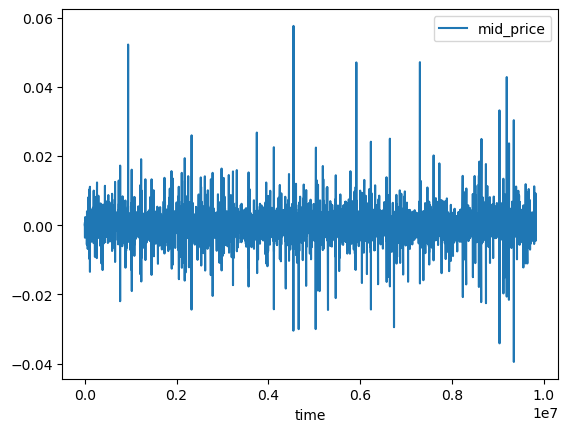

In [9]:
train_stock0['time'] = train_stock0['time_id'].astype(int)*60*5 + train_stock0['seconds_in_bucket']
train_stock0[['time', 'mid_price']].set_index('time').diff().plot()

In [10]:
from helper_functions.afml_functions.afml_modelling_lib import quantile_encode_series, shannon_entropy, encode_and_entropy

In [11]:
train_stock0['encoded_ret'] = quantile_encode_series(train_stock0['mid_price'].diff())

In [12]:
train_stock0['log_ret'] = np.log(train_stock0['mid_price']) - np.log(train_stock0['mid_price'].shift())

In [14]:
import itertools
best_rsqd = 0
best_qL = (2, 10)
for q, L in itertools.product([10, 15, 20], [10, 50, 100]):
    train_stock0['entropy'] = train_stock0[['time_id', 'log_ret']].dropna().groupby('time_id').apply(lambda x: shannon_entropy(quantile_encode_series(x['log_ret'], q).astype(str), L))
    stock0_entropy_target = pd.DataFrame(train_stock0['entropy'].dropna()).join(train_target[train_target['stock_id'] == 0].set_index('time_id')[['target']])
    mod = sm.OLS(stock0_entropy_target['target'], stock0_entropy_target[['entropy']])
    res = mod.fit()
    print(q, L, res.rsquared)
    best_rsqd = max(res.rsquared, best_rsqd)
    if res.rsquared == best_rsqd:
        best_qL = (q, L)
print(best_qL, best_rsqd)

10 10 0.6414634613006582
10 50 0.675963237347308


KeyboardInterrupt: 

### features to construct
(all should be averages with the interval of interest)
- diff between VWAP and midprice
- volume imbalance
- spread
- gradient of bid side book (bid_size_1 - bid_size2)/(bid_price_2 - bid_price_1)
- gradient of ask side book
- entropy contained in encoded midprice (it looks like the mid price is stationary)
- entropy contained in fractionally differenced VWAP
- entropy in the differences
- average difference between trade price and ask (weighted by size)
- average difference between trade price and bid (weighted by size)
- vol of various quantities above
- correlation of stock with clustered stocks
- vol is mean reverting - would be good to put some mean reverting ideas in here (OU or some signal relating to this)

(calculate within a function to make life easier later!)
We'll try calibrating by instrument separately and then trying to get one general model, themn maybe we'll try something to combine

In [ ]:
book_train_all_stocks.head()

In [ ]:
X = pd.DataFrame(book_train_all_stocks[['time_id', 'stock_id']])

In [23]:
from helper_functions.afml_functions.afml_data_analysis_lib import frac_diff_ffd
from sklearn.decomposition import PCA 

def calculate_on_all_time_points(df):
    # order book features
    df['VWAP'] = (df['bid_price1']*df['bid_size1'] + df['bid_price2']*df['bid_size2'] + df['ask_price1']*df['ask_size1'] + df['ask_price2']*df['ask_size2'])/(df['bid_size1'] + df['bid_size2'] + df['ask_size1'] + df['ask_size2'])
    df['mid_price'] = (df['ask_price1'] + df['bid_price1'])/2
    df['VWAP_mid_price_diff'] = df['VWAP'] - df['mid_price']
    df['volume_imbalance'] = df['ask_size1'] + df['ask_size2'] - df['bid_size1'] - df['bid_size2']
    df['spread'] = (df['ask_price1'] - df['bid_price1'])/df['mid_price']
    df['deeper_spread'] = df['ask_price2'] - df['bid_price2']
    df['spread_ratio'] = df['spread'] / df['deeper_spread']
    df['bid_gradient'] = (df['bid_size2'] - df['bid_size1'])/(df['bid_price2'] - df['bid_price1'])
    df['ask_gradient'] = (df['ask_size1'] - df['ask_size2'])/(df['ask_price1'] - df['ask_price2'])
    df['total_buy_interest'] = df['bid_price1'] + df['bid_price2']
    df['total_sell_interest'] = df['ask_price1'] + df['ask_price2']
    df['log_ret'] = np.log(df['mid_price']) - np.log(df['mid_price'].shift())

    # trade features
    df['bid_trade_diff'] = df['price'] - df['bid_price1']
    df['ask_trade_diff'] = df['ask_price1'] - df['price']
    return df

def weighted_average(data: pd.DataFrame, val_col: str, weights_col: str) -> float:
    return (data[val_col] * data[weights_col]).sum() / data[weights_col].sum()


def calculate_aggregate_features(df):
    # volume features
    aggregate = pd.DataFrame()
    aggregate['total_buy_interest'] = df[['time_id', 'stock_id', 'total_buy_interest']].groupby(['stock_id', 'time_id']).sum()
    aggregate['total_sell_interest'] = df[['time_id', 'stock_id', 'total_sell_interest']].groupby(['stock_id', 'time_id']).sum()
    aggregate['mean_buy_interest'] = df[['time_id', 'stock_id', 'total_buy_interest']].groupby(['stock_id', 'time_id']).mean()
    aggregate['mean_sell_interest'] = df[['time_id', 'stock_id', 'total_sell_interest']].groupby(['stock_id', 'time_id']).mean()
    aggregate['std_imbalance'] = df[['time_id', 'stock_id', 'volume_imbalance']].groupby(['stock_id', 'time_id']).std()
    aggregate['total_imbalance_pct'] = (aggregate['total_buy_interest'] - aggregate['total_sell_interest']) / (aggregate['total_buy_interest'] + aggregate['total_sell_interest'])

    # traded volume features
    aggregate['total_traded_size'] = df[['time_id', 'stock_id', 'size']].groupby(['stock_id', 'time_id']).sum()
    aggregate['total_order_count'] = df[['time_id', 'stock_id', 'order_count']].groupby(['stock_id', 'time_id']).sum()
    aggregate['average_order_size'] = aggregate['total_traded_size'] / aggregate['total_order_count']
    aggregate['pct_interest_traded'] = aggregate['total_traded_size'] / (aggregate['total_buy_interest'] + aggregate['total_sell_interest'])

    # price features
    aggregate['mean_bid_trade_diff_weighted'] = df[['time_id', 'stock_id', 'bid_trade_diff', 'size']].groupby(['stock_id', 'time_id']).apply(lambda x: weighted_average(x, 'bid_trade_diff', 'size'))
    aggregate['mean_ask_trade_diff_weighted'] = df[['time_id', 'stock_id', 'ask_trade_diff', 'size']].groupby(['stock_id', 'time_id']).apply(lambda x: weighted_average(x, 'ask_trade_diff', 'size'))
    aggregate['mean_VWAP_mid_price_diff'] = df[['time_id', 'stock_id', 'VWAP_mid_price_diff']].groupby(['stock_id', 'time_id']).mean()
    aggregate['mean_mid_price'] = df[['time_id', 'stock_id', 'mid_price']].groupby(['stock_id', 'time_id']).mean()
    aggregate['mean_VWAP'] = df[['time_id', 'stock_id', 'VWAP']].groupby(['stock_id', 'time_id']).mean()
    aggregate['std_VWAP_mid_price_diff'] = df[['time_id', 'stock_id', 'VWAP_mid_price_diff']].groupby(['stock_id', 'time_id']).std()
    aggregate['std_ret'] = df[['time_id', 'stock_id', 'log_ret']].dropna().groupby(['stock_id', 'time_id']).std()
    aggregate['std_VWAP'] = df[['time_id', 'stock_id', 'VWAP']].groupby(['stock_id', 'time_id']).std()
    aggregate['mean_bid_gradient'] = df[['time_id', 'stock_id', 'bid_gradient']].groupby(['stock_id', 'time_id']).mean()
    aggregate['mean_ask_gradient'] = df[['time_id', 'stock_id', 'ask_gradient']].groupby(['stock_id', 'time_id']).mean()
    aggregate['std_bid_gradient'] = df[['time_id', 'stock_id', 'bid_gradient']].groupby(['stock_id', 'time_id']).std()
    aggregate['std_ask_gradient'] = df[['time_id', 'stock_id', 'ask_gradient']].groupby(['stock_id', 'time_id']).std()
    aggregate['mean_spread_ratio'] = df[['time_id', 'stock_id', 'spread_ratio']].groupby(['stock_id', 'time_id']).mean()
    aggregate['std_spread_ratio'] = df[['time_id', 'stock_id', 'spread_ratio']].groupby(['stock_id', 'time_id']).std()

    # entropy features
    q, L = 20, 100
    aggregate['entropy_ret'] = df[['time_id', 'stock_id', 'log_ret']].dropna().groupby(['stock_id', 'time_id']).apply(lambda x: shannon_entropy(quantile_encode_series(x['log_ret'], q).astype(str), L))
    aggregate['entropy_VWAP'] = df[['time_id', 'stock_id', 'VWAP']].dropna().groupby(['stock_id', 'time_id']).apply(lambda x: shannon_entropy(quantile_encode_series(x['VWAP'], q).astype(str), L))
    aggregate['entropy_vol_ratio_ret'] = aggregate['entropy_ret'] / aggregate['std_ret']
    aggregate['entropy_vol_ratio_VWAP'] = aggregate['entropy_VWAP'] / aggregate['std_VWAP']

    # correlation features
    pca_stock_dict = df.groupby('time_id').apply(pca_correlation_measure)
    pca = dict_series_to_multi_index_df(pca_stock_dict)
    pca.columns = ['pca_corr']
    aggregate = aggregate.join(pca, how='inner')
    pearson_corr_stock_dict = df.groupby('time_id').apply(lambda x: corr(x, 'pearson'))
    pearson_corr = dict_series_to_multi_index_df(pearson_corr_stock_dict)
    pearson_corr.columns = ['pearson_corr']
    aggregate = aggregate.join(pearson_corr, how='inner')
    spearman_corr_stock_dict = df.groupby('time_id').apply(lambda x: corr(x, 'spearman'))
    spearman_corr = dict_series_to_multi_index_df(spearman_corr_stock_dict)
    spearman_corr.columns = ['spearman_corr']
    aggregate = aggregate.join(spearman_corr, how='inner')
    
    return aggregate

# could be made more efficient if we didnt have to do this every time for every stock but will accept for now...
# function has memory problems, lets come back to this
def pca_correlation_measure(df: pd.DataFrame) -> float:
    prices_pivoted = df[['seconds_in_bucket', 'stock_id', 'mid_price']].pivot(index='seconds_in_bucket', columns='stock_id', values='mid_price') 
    prices = prices_pivoted.fillna(method='ffill')
    returns = np.log(prices) - np.log(prices.shift())
    returns.dropna(inplace=True)
    pca = PCA(n_components=1)
    pca.fit(returns)
    stock_to_pca = dict(zip(list(prices.columns), list(pca.components_.flatten())))
    return stock_to_pca

def corr(df: pd.DataFrame, method: str = 'pearson'):
    prices_pivoted = df[['seconds_in_bucket', 'stock_id', 'mid_price']].pivot(index='seconds_in_bucket', columns='stock_id', values='mid_price') 
    prices = prices_pivoted.fillna(method='ffill')
    returns = np.log(prices) - np.log(prices.shift())
    returns.dropna(inplace=True)
    corr_matrix = returns.corr(method=method)
    mean_per_stock = corr_matrix.mean()
    stock_to_corr = dict(mean_per_stock)
    return stock_to_corr
    
    
def dict_series_to_multi_index_df(series: pd.Series):
    res = pd.DataFrame(series.tolist(), index=series.index) # convert the resulting series of dictionaries to a DataFrame
    res = res.stack().reset_index() # unstack the DataFrame to have time_id and stock_id as indices
    res.columns = ['time_id', 'stock_id', 'value']
    res.set_index(['time_id', 'stock_id'], inplace=True) # set time_id and stock_id as indices
    return res


In [ ]:
train_decorated = calculate_on_all_time_points(book_train_all_stocks)

In [29]:
time_ids = book_train_all_stocks['time_id'].unique()
i = 0
subset_time_id_length = 100
aggregate_features_list = []
while i <= time_ids[-1]:
    max_ind = min(time_ids[-1], i+subset_time_id_length)
    subset_book_train = book_train_all_stocks[(book_train_all_stocks['time_id'] >= i) & (book_train_all_stocks['time_id'] <= max_ind)]
    subset_trade_train = trade_train_all_stocks[(trade_train_all_stocks['time_id'] >= i) & (trade_train_all_stocks['time_id'] <= max_ind)]
    all_data = pd.merge(subset_book_train, subset_trade_train, how='outer', on=['stock_id', 'time_id', 'seconds_in_bucket'])
    features_all_time_points = calculate_on_all_time_points(all_data)
    aggregate_features = calculate_aggregate_features(features_all_time_points)
    aggregate_features_list.append(aggregate_features)
    i += subset_time_id_length
    print('pct complete:', i / time_ids[-1])

features = pd.concat(aggregate_features_list)
features.to_csv('generated_features_volatily_pred.csv')

pct complete: 0.0030518509475997192
pct complete: 0.0061037018951994385
pct complete: 0.009155552842799158
pct complete: 0.012207403790398877
pct complete: 0.015259254737998596
pct complete: 0.018311105685598315
pct complete: 0.021362956633198035
pct complete: 0.024414807580797754
pct complete: 0.027466658528397473
pct complete: 0.030518509475997192
pct complete: 0.033570360423596915
pct complete: 0.03662221137119663
pct complete: 0.03967406231879635
pct complete: 0.04272591326639607
pct complete: 0.04577776421399579
pct complete: 0.04882961516159551
pct complete: 0.05188146610919523
pct complete: 0.054933317056794946
pct complete: 0.05798516800439467
pct complete: 0.061037018951994385
pct complete: 0.0640888698995941
pct complete: 0.06714072084719383
pct complete: 0.07019257179479355
pct complete: 0.07324442274239326
pct complete: 0.07629627368999298
pct complete: 0.0793481246375927
pct complete: 0.08239997558519242
pct complete: 0.08545182653279214
pct complete: 0.08850367748039185
p

In [32]:
features

total_buy_interest  total_sell_interest  mean_buy_interest  \
stock_id time_id                                                               
0        5                605.948669           606.563721           2.006453   
         11               399.976166           400.189240           1.999881   
         16               375.663666           376.010437           1.998211   
         31               239.604050           239.846069           1.996700   
         62               351.757721           351.950226           1.998623   
...                              ...                  ...                ...   
126      32751            619.348938           619.983826           1.997900   
         32753            446.871704           447.247131           2.003909   
         32758            512.185486           512.661621           2.000725   
         32763            799.228333           799.762451           2.003078   
         32767            434.010681           434.256073           2.000049   

                  mean_sell_interest  std_imbalance  total_imbalance_pct  \
stock_id time_id                                                           
0        5                  2.008489     172.436952            -0.000507   
         11                 2.000946     156.143772            -0.000266   
         16                 2.000056     178.710949            -0.000461   
         31                 1.998717     177.646811            -0.000505   
         62                 1.999717     143.818118            -0.000274   
...                              ...            ...                  ...   
126      32751              1.999948     191.816892            -0.000512   
         32753              2.005593     169.722970            -0.000420   
         32758              2.002584     183.311511            -0.000465   
         32763              2.004417     165.993902            -0.000334   
         32767              2.001180     233.870513            -0.000283   

                  total_traded_size  total_order_count  average_order_size  \
stock_id time_id                                                             
0        5                   3179.0              110.0           28.900000   
         11                  1289.0               57.0           22.614035   
         16                  2161.0               68.0           31.779412   
         31                  1962.0               59.0           33.254237   
         62                  1791.0               89.0           20.123596   
...                             ...                ...                 ...   
126      32751               2570.0              103.0           24.951456   
         32753               2323.0              147.0           15.802721   
         32758               3740.0               98.0           38.163265   
         32763               9389.0              234.0           40.123932   
         32767               5325.0              108.0           49.305556   

                  pct_interest_traded  ...  std_ask_gradient  \
stock_id time_id                       ...                     
0        5                   2.621829  ...      1.113258e+06   
         11                  1.610917  ...      1.437666e+06   
         16                  2.874916  ...      1.270742e+06   
         31                  4.092188  ...      2.010502e+06   
         62                  2.545090  ...      1.865566e+06   
...                               ...  ...               ...   
126      32751               2.073696  ...      1.622995e+06   
         32753               2.598089  ...      1.047169e+06   
         32758               3.649325  ...      7.126565e+05   
         32763               5.871829  ...      1.427264e+06   
         32767               6.132908  ...      2.346428e+06   

                  mean_spread_ratio  std_spread_ratio  entropy_ret  \
stock_id time_id                                                     


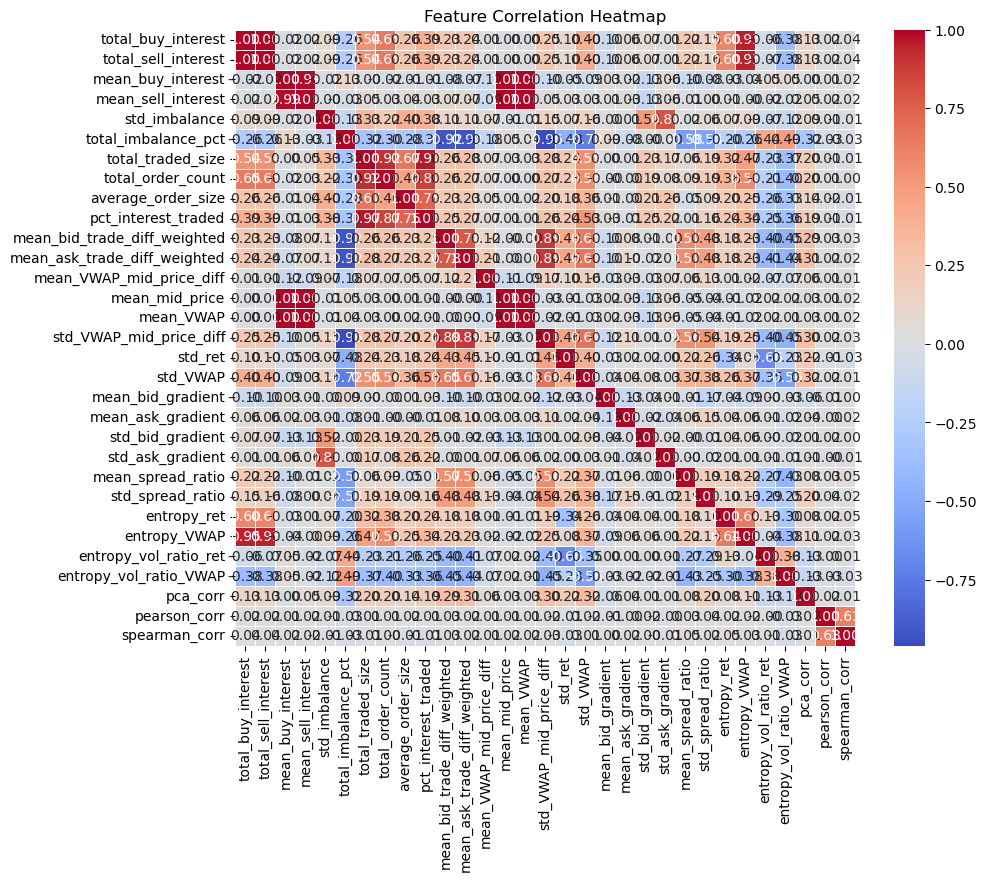

In [41]:
from helper_functions.general.feature_selection import generate_heatmap, linear_model_with_pvalue_threshold, linear_model_with_anova_f_test, feature_importance_mdi_pmf_with_rf

generate_heatmap(features.loc[100, :])

In [50]:
target = train_target.set_index(['stock_id', 'time_id'])
target_and_features = features.join(target, on=['stock_id', 'time_id'], how='inner')
target_and_features.dropna(inplace=True)

In [54]:
reduced_features = linear_model_with_pvalue_threshold(target_and_features.drop('target', axis=1), target_and_features['target'])[0]

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                 4.868e+04
Date:                Tue, 15 Oct 2024   Prob (F-statistic):               0.00
Time:                        21:55:17   Log-Likelihood:             2.2295e+06
No. Observations:              433158   AIC:                        -4.459e+06
Df Residuals:                  433127   BIC:                        -4.459e+06
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [55]:
reduced_features

total_buy_interest  total_sell_interest  mean_buy_interest  \
stock_id time_id                                                               
0        5                605.948669           606.563721           2.006453   
         11               399.976166           400.189240           1.999881   
         16               375.663666           376.010437           1.998211   
         31               239.604050           239.846069           1.996700   
         62               351.757721           351.950226           1.998623   
...                              ...                  ...                ...   
126      32751            619.348938           619.983826           1.997900   
         32753            446.871704           447.247131           2.003909   
         32758            512.185486           512.661621           2.000725   
         32763            799.228333           799.762451           2.003078   
         32767            434.010681           434.256073           2.000049   

                  mean_sell_interest  std_imbalance  total_imbalance_pct  \
stock_id time_id                                                           
0        5                  2.008489     172.436952            -0.000507   
         11                 2.000946     156.143772            -0.000266   
         16                 2.000056     178.710949            -0.000461   
         31                 1.998717     177.646811            -0.000505   
         62                 1.999717     143.818118            -0.000274   
...                              ...            ...                  ...   
126      32751              1.999948     191.816892            -0.000512   
         32753              2.005593     169.722970            -0.000420   
         32758              2.002584     183.311511            -0.000465   
         32763              2.004417     165.993902            -0.000334   
         32767              2.001180     233.870513            -0.000283   

                  total_traded_size  total_order_count  average_order_size  \
stock_id time_id                                                             
0        5                   3179.0              110.0           28.900000   
         11                  1289.0               57.0           22.614035   
         16                  2161.0               68.0           31.779412   
         31                  1962.0               59.0           33.254237   
         62                  1791.0               89.0           20.123596   
...                             ...                ...                 ...   
126      32751               2570.0              103.0           24.951456   
         32753               2323.0              147.0           15.802721   
         32758               3740.0               98.0           38.163265   
         32763               9389.0              234.0           40.123932   
         32767               5325.0              108.0           49.305556   

                  pct_interest_traded  ...  std_bid_gradient  \
stock_id time_id                       ...                     
0        5                   2.621829  ...      1.525469e+06   
         11                  1.610917  ...      2.707682e+06   
         16                  2.874916  ...      1.542514e+06   
         31                  4.092188  ...      2.343093e+06   
         62                  2.545090  ...      1.242280e+06   
...                               ...  ...               ...   
126      32751               2.073696  ...      3.219414e+06   
         32753               2.598089  ...      2.294470e+06   
         32758               3.649325  ...      2.607462e+06   
         32763               5.871829  ...      1.282602e+06   
         32767               6.132908  ...      1.557494e+06   

                  std_ask_gradient  mean_spread_ratio  std_spread_ratio  \
stock_id time_id                                                 

base model                             OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                 5.616e+04
Date:                Tue, 15 Oct 2024   Prob (F-statistic):               0.00
Time:                        21:56:54   Log-Likelihood:             2.2294e+06
No. Observations:              433158   AIC:                        -4.459e+06
Df Residuals:                  433131   BIC:                        -4.459e+06
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const

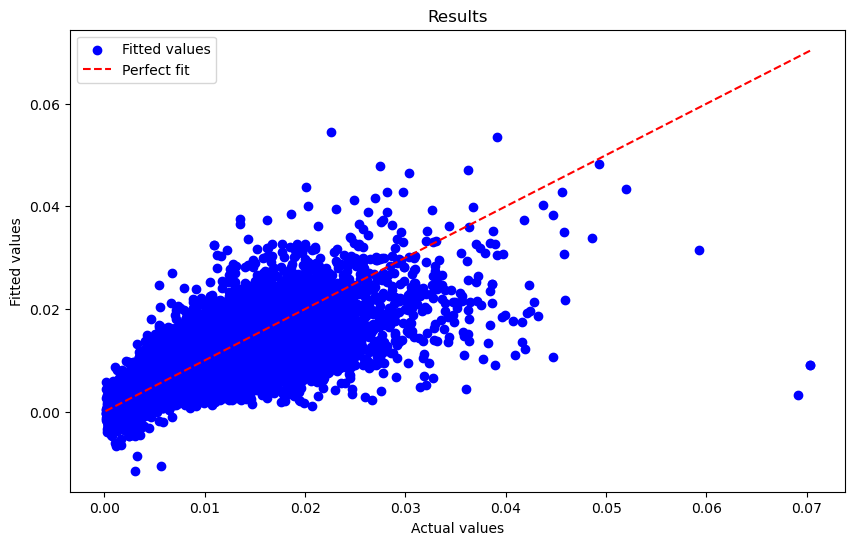

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2592ace10f0>,
                   total_buy_interest  total_sell_interest  mean_buy_interest  \
 stock_id time_id                                                               
 0        5                605.948669           606.563721           2.006453   
          11               399.976166           400.189240           1.999881   
          16               375.663666           376.010437           1.998211   
          31               239.604050           239.846069           1.996700   
          62               351.757721           351.950226           1.998623   
 ...                              ...                  ...                ...   
 126      32751            619.348938           619.983826           1.997900   
          32753            446.871704           447.247131           2.003909   
          32758            512.185486           512.661621           2.000725   
          32763            

In [56]:
linear_model_with_anova_f_test(reduced_features, target_and_features['target'])

In [ ]:
feature_importance_mdi_pmf_with_rf(reduced_features, target_and_features['target'])

completed training
obtained MDI feature importances
